In [18]:
# This script shows how scans that have been corrected are producing motion estimates that are noisier,
# for both interpolation and spline correction. Not sure why this is happening.

# Comparing RO to INS data

import sys
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts")
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts/config")
from figs import plot
import motion

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
from numpy import *

import module
import settings

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rc("font", family=settings.FONT_FAMILY)
plt.rcParams['axes.titlepad'] = 20
plt.rcParams.update({'font.size': 16}) # was 28
plt.rcParams['axes.grid'] = True
plt.rcParams['text.usetex'] = True
# text

module.set_sys_paths()

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

import numpy as np
from config.data import *

colour_ro = u'#d62728' #red
colour_spline = u'#1f77b4' #blue
colour_interpolation = u'#ff7f0e' #orange
colour_aux_1 = u'#2ca02c' #green
colour_ins = 'black' #black

In [19]:
dataset_path = "/tmp/"

RO_relative_poses_path = dataset_path+"ro_relative_poses.monolithic"
interpolation_relative_poses_path = dataset_path+"ro_relative_poses_interpolation_corrected.monolithic"
# spline_relative_poses_path = dataset_path+"ro_relative_poses_spline.monolithic"
spline_relative_poses_path = dataset_path+"ro_relative_poses_spline_corrected.monolithic"

In [20]:
# RO - open monolithic and iterate frames
print("reading RO_relative_poses_path: " + RO_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    RO_relative_poses_path)

# iterate mono
RO_se3s = []
RO_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    RO_se3s.append(serialised_transform[0])
    RO_timestamps.append(serialised_transform[1])

# Interpolated RO - open monolithic and iterate frames
print("reading interpolation_relative_poses_path: " + interpolation_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    interpolation_relative_poses_path)

# iterate mono
interpolation_se3s = []
interpolation_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    interpolation_se3s.append(serialised_transform[0])
    interpolation_timestamps.append(serialised_transform[1])
    
# Splined RO - open monolithic and iterate frames
print("reading spline_relative_poses_path: " + spline_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    spline_relative_poses_path)

# iterate mono
spline_se3s = []
spline_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    spline_se3s.append(serialised_transform[0])
    spline_timestamps.append(serialised_transform[1])
    
print("\nFinished importing.")

print(RO_timestamps[0])
print(spline_timestamps[0])
print("Initial timestamp difference: ", RO_timestamps[0] - spline_timestamps[0])

# RO_se3s = RO_se3s[3:]
# RO_timestamps = RO_timestamps[3:]
# print("Cropped first 3 estimates from RO for easier data analysis when comparing with spline estimates (they are two poses behind).")

RO_se3s = RO_se3s[2:]
RO_timestamps = RO_timestamps[2:]
interpolation_se3s = interpolation_se3s[1:]
interpolation_timestamps = interpolation_timestamps[1:]
print("Cropped first 2 estimates from RO for easier data analysis when comparing with spline estimates (they are two poses behind).")

print(RO_timestamps[0])
print(spline_timestamps[0])
print("Cropped timestamp difference: ", RO_timestamps[0] - spline_timestamps[0])

reading RO_relative_poses_path: /tmp/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
reading interpolation_relative_poses_path: /tmp/ro_relative_poses_interpolation_corrected.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
reading spline_relative_poses_path: /tmp/ro_relative_poses_spline_corrected.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2

Finished importing.
1503051705355940
1503051705855215
Initial timestamp difference:  -499275
Cropped first 2 estimates from RO for easier data analysis when comparing with spline estimates (they are two poses behind).
1503051705855215
1503051705855215
Cropped timestamp difference:  0


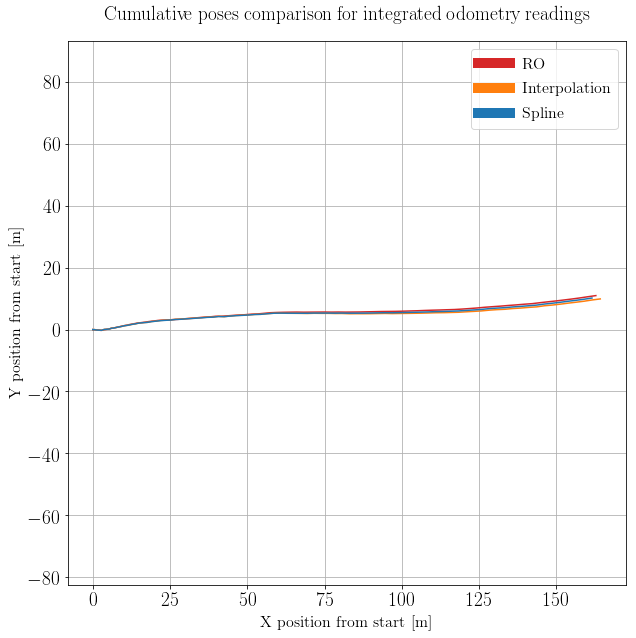

In [21]:
# get RO poses
RO_poses = []
pose = np.identity(4)
for i in range(len(RO_se3s)):
    pose = pose * RO_se3s[i]
    RO_poses.append(pose)

# get x,y coords
x_RO = [pose[0, 3] for pose in RO_poses]
y_RO = [pose[1, 3] for pose in RO_poses]

# get interpolation poses
interpolation_poses = []
pose = np.identity(4)
for i in range(len(interpolation_se3s)):
    pose = pose * interpolation_se3s[i]
    interpolation_poses.append(pose)

# get x,y coords
x_interpolation = [pose[0, 3] for pose in interpolation_poses]
y_interpolation = [pose[1, 3] for pose in interpolation_poses]

# get spline poses
spline_poses = []
pose = np.identity(4)
for i in range(len(spline_se3s)):
    pose = pose * spline_se3s[i]
    spline_poses.append(pose)

# get x,y coords
x_spline = [pose[0, 3] for pose in spline_poses]
y_spline = [pose[1, 3] for pose in spline_poses]

plt.figure(figsize=(10,10)) # was 15,15
plt.plot(x_RO,y_RO,'-',color=colour_ro,markersize=1);
plt.plot(x_interpolation,y_interpolation,'-',color=colour_interpolation,markersize=1);
plt.plot(x_spline,y_spline,'-',color=colour_spline,markersize=1);
plt.axis('equal');
plt.title('Cumulative poses comparison for integrated odometry readings');
plt.xlabel('X position from start [m]');
plt.ylabel('Y position from start [m]');
line2, = plt.plot([],[],color=colour_ro,label='RO',linewidth=10.0)
line3, = plt.plot([],[],color=colour_interpolation,label='Interpolation',linewidth=10.0)
line4, = plt.plot([],[],color=colour_spline,label='Spline',linewidth=10.0)
# plt.xlim(150, 200)
# plt.ylim(0,20)

plt.legend(handles=[line2,line3,line4],loc='best')
plt.savefig(dataset_path+"figs/filename_all_poses.pdf",bbox_inches='tight',pad_inches = 0)

In [22]:
# RO_se3s[i][0,3]

6.066971791873504
8.261819361153044
10.956123555095779


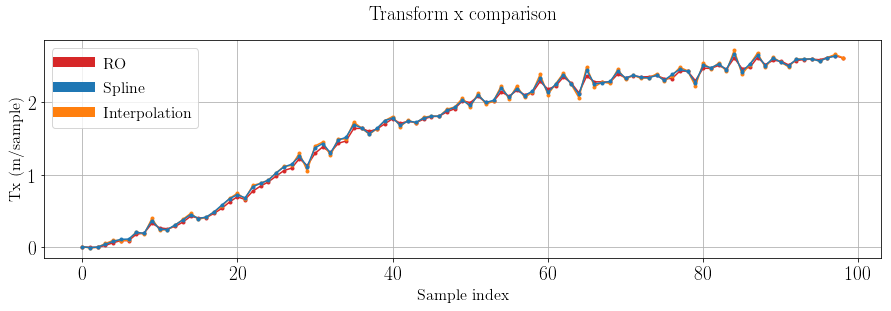

In [23]:
# get RO tx
RO_tx = []
for i in range(1,len(RO_se3s)):
    RO_tx.append(RO_se3s[i][0,3])
    
# get interpolation tx
interpolation_tx = []
for i in range(1,len(interpolation_se3s)):
    interpolation_tx.append(interpolation_se3s[i][0,3])
    
# get spline tx
spline_tx = []
for i in range(1,len(spline_se3s)):
    spline_tx.append(spline_se3s[i][0,3])
    
# Velocities
plt.figure(figsize=(15,4))
plt.plot(RO_tx,'.-',color=colour_ro);
plt.plot(interpolation_tx,'.-',color=colour_interpolation);
plt.plot(spline_tx,'.-',color=colour_spline);

# plt.ylim(6,8)
# plt.xlim(150,350)
line2, = plt.plot([],[],color=colour_ro,label='RO',linewidth=10.0)
line3, = plt.plot([],[],color=colour_spline,label='Spline',linewidth=10.0)
line4, = plt.plot([],[],color=colour_interpolation,label='Interpolation',linewidth=10.0)

plt.legend(handles=[line2,line3,line4],loc='best')
plt.title('Transform x comparison')
plt.xlabel('Sample index')
plt.ylabel('Tx (m/sample)')
#-----------------------------------------------------------------------------
print(np.sum(np.abs(np.diff(RO_tx))))
print(np.sum(np.abs(np.diff(spline_tx))))
print(np.sum(np.abs(np.diff(interpolation_tx))))


Text(0,0.5,'Ty (m/sample)')

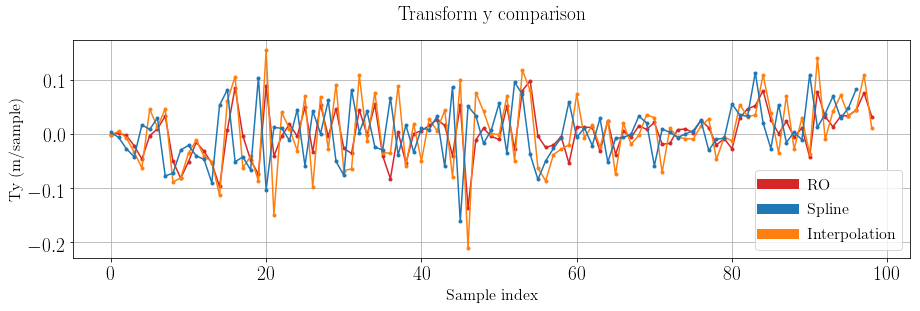

In [24]:
# get RO ty
RO_ty = []
for i in range(1,len(RO_se3s)):
    RO_ty.append(RO_se3s[i][1,3])
    
# get interpolation ty
interpolation_ty = []
for i in range(1,len(interpolation_se3s)):
    interpolation_ty.append(interpolation_se3s[i][1,3])
    
# get spline ty
spline_ty = []
for i in range(2,len(spline_se3s)):
    spline_ty.append(spline_se3s[i][1,3])
    
# Velocities
plt.figure(figsize=(15,4))
plt.plot(RO_ty,'.-',color=colour_ro);
plt.plot(interpolation_ty,'.-',color=colour_interpolation);
plt.plot(spline_ty,'.-',color=colour_spline);

# plt.ylim(6,8)
# plt.xlim(150,250)
line2, = plt.plot([],[],color=colour_ro,label='RO',linewidth=10.0)
line3, = plt.plot([],[],color=colour_spline,label='Spline',linewidth=10.0)
line4, = plt.plot([],[],color=colour_interpolation,label='Interpolation',linewidth=10.0)

plt.legend(handles=[line2,line3,line4],loc='best')
plt.title('Transform y comparison')
plt.xlabel('Sample index')
plt.ylabel('Ty (m/sample)')
#-----------------------------------------------------------------------------


In [25]:
# get speeds
assert len(RO_se3s) == len(RO_timestamps)
RO_speeds = []
RO_TIMESTAMPS = []
deltatime_arr = []
for i in range(1,len(RO_timestamps)):
    # work out speed
    delta_time = (RO_timestamps[i] - RO_timestamps[i - 1]) / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = RO_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    RO_speeds.append(speed)
    RO_TIMESTAMPS.append(RO_timestamps[i])
    
assert len(interpolation_se3s) == len(interpolation_timestamps)
interpolation_speeds = []
interpolation_TIMESTAMPS = []
deltatime_arr = []
for i in range(1,len(interpolation_timestamps)):
    # work out speed
    delta_time = (interpolation_timestamps[i] - interpolation_timestamps[i - 1]) / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = interpolation_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    interpolation_speeds.append(speed)
    interpolation_TIMESTAMPS.append(interpolation_timestamps[i])
    
# Technically there's a more principled way to determine speed from the control points using spline fusion
# This method is naive differentiation, but the speeds will change slightly depending 
# on the resolution of the estimated points
assert len(spline_se3s) == len(spline_timestamps)
spline_speeds = []
spline_TIMESTAMPS = []
deltatime_arr = []
for i in range(1,len(spline_timestamps)):
    # work out speed
    delta_time = (spline_timestamps[i] - spline_timestamps[i - 1]) / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = spline_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    spline_speeds.append(speed)
    spline_TIMESTAMPS.append(spline_timestamps[i])
    
RO_seconds = [(timestamp - RO_TIMESTAMPS[0]) / settings.TIMESTAMP_CONVERSION for timestamp in RO_TIMESTAMPS]
interpolation_seconds = [(timestamp - interpolation_TIMESTAMPS[0]) / settings.TIMESTAMP_CONVERSION for timestamp in interpolation_TIMESTAMPS]
spline_seconds = [(timestamp - spline_TIMESTAMPS[0]) / settings.TIMESTAMP_CONVERSION for timestamp in spline_TIMESTAMPS]

In [26]:
RO_thetas = [np.arctan2(x[1, 0], x[0, 0]) for x in RO_se3s]
interpolation_thetas = [np.arctan2(x[1, 0], x[0, 0]) for x in interpolation_se3s]
spline_thetas = [np.arctan2(x[1, 0], x[0, 0]) for x in spline_se3s]

# RO yaw rates
RO_yaw_rates = []
for i in range(len(RO_timestamps) - 1):
    delta_time = (RO_timestamps[i + 1] - RO_timestamps[i]) / settings.TIMESTAMP_CONVERSION
    yaw_rate = RO_thetas[i] / delta_time
    RO_yaw_rates.append(yaw_rate)
    
# Interpolation yaw rates
interpolation_yaw_rates = []
for i in range(len(interpolation_timestamps) - 1):
    delta_time = (interpolation_timestamps[i + 1] - interpolation_timestamps[i]) / settings.TIMESTAMP_CONVERSION
    yaw_rate = interpolation_thetas[i] / delta_time
    interpolation_yaw_rates.append(yaw_rate)    

# Spline yaw rates
spline_yaw_rates = []
for i in range(len(spline_timestamps) - 1):
    delta_time = (spline_timestamps[i + 1] - spline_timestamps[i]) / settings.TIMESTAMP_CONVERSION
    yaw_rate = spline_thetas[i] / delta_time
    spline_yaw_rates.append(yaw_rate)

Text(0,0.5,'Velocity (m/s)')

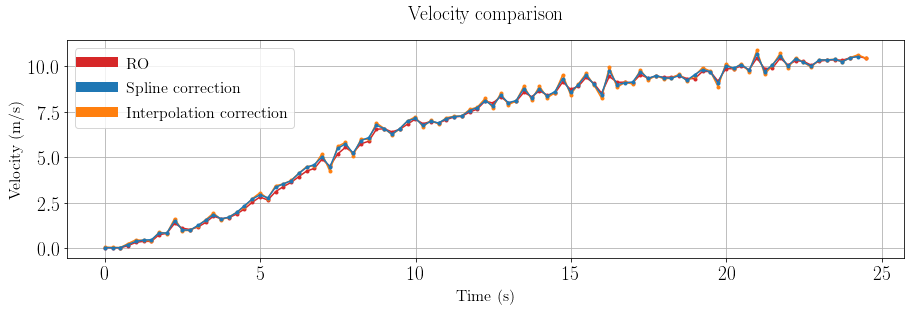

In [31]:
# Velocities
plt.figure(figsize=(15,4))
plt.plot(RO_seconds,RO_speeds,'.-',color=colour_ro);
plt.plot(interpolation_seconds,interpolation_speeds,'.-',color=colour_interpolation);
plt.plot(spline_seconds,spline_speeds,'.-',color=colour_spline);

# plt.ylim(6,8)
# plt.xlim(5,10)
line2, = plt.plot([],[],color=colour_ro,label='RO',linewidth=10.0)
line3, = plt.plot([],[],color=colour_spline,label='Spline correction',linewidth=10.0)
line4, = plt.plot([],[],color=colour_interpolation,label='Interpolation correction',linewidth=10.0)

plt.legend(handles=[line2,line3,line4],loc='best')
plt.title('Velocity comparison')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
#-----------------------------------------------------------------------------


Text(0,0.5,'Velocity (rad/s)')

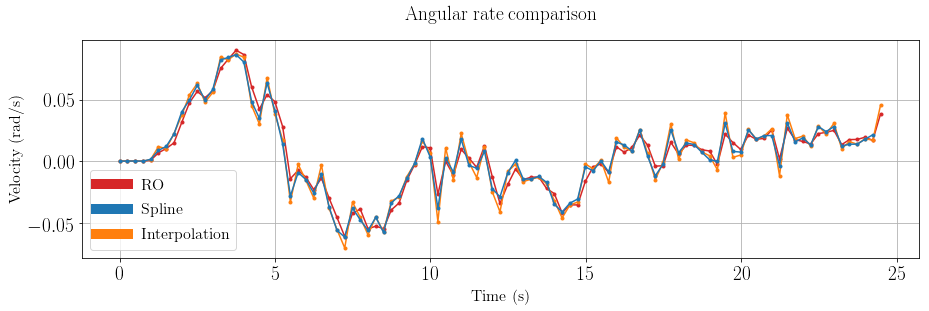

In [28]:
# Angular rates
plt.figure(figsize=(15,4))
plt.plot(RO_seconds,RO_yaw_rates,'.-',color=colour_ro)
plt.plot(interpolation_seconds,interpolation_yaw_rates,'.-',color=colour_interpolation)
plt.plot(spline_seconds,spline_yaw_rates,'.-',color=colour_spline)

line2, = plt.plot([],[],color=colour_ro,label='RO',linewidth=10.0)
line3, = plt.plot([],[],color=colour_spline,label='Spline',linewidth=10.0)
line4, = plt.plot([],[],color=colour_interpolation,label='Interpolation',linewidth=10.0)
# plt.xlim(80, 100)
# plt.ylim(0.025,0.05)
plt.legend(handles=[line2,line3,line4],loc='best')
plt.title('Angular rate comparison')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (rad/s)')

Text(0,0.5,'Velocity (m/s)')

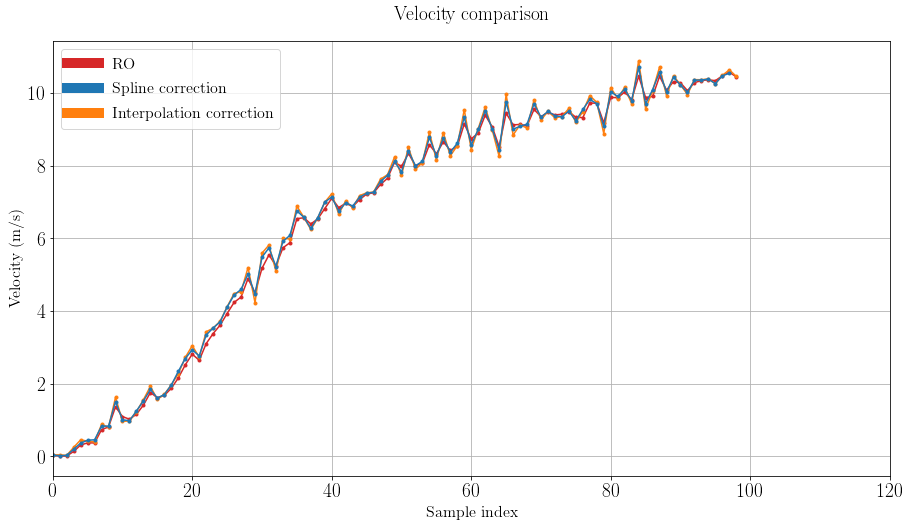

In [32]:
# Velocities
plt.figure(figsize=(15,8))
plt.plot(RO_speeds,'.-',color=colour_ro);
plt.plot(interpolation_speeds,'.-',color=colour_interpolation);
plt.plot(spline_speeds,'.-',color=colour_spline);

# plt.ylim(-1,12)
plt.xlim(0,120)

line2, = plt.plot([],[],color=colour_ro,label='RO',linewidth=10.0)
line3, = plt.plot([],[],color=colour_spline,label='Spline correction',linewidth=10.0)
line4, = plt.plot([],[],color=colour_interpolation,label='Interpolation correction',linewidth=10.0)
plt.legend(handles=[line2,line3,line4],loc='best')
plt.title('Velocity comparison')
plt.xlabel('Sample index')
plt.ylabel('Velocity (m/s)')
#-----------------------------------------------------------------------------


Text(0,0.5,'Velocity (rad/s)')

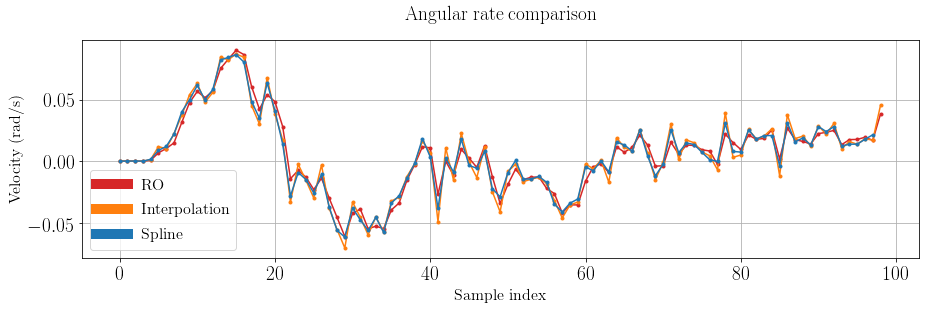

In [30]:
# Angular rates
plt.figure(figsize=(15,4))
plt.plot(RO_yaw_rates,'.-',color=colour_ro)
plt.plot(interpolation_yaw_rates,'.-',color=colour_interpolation)
plt.plot(spline_yaw_rates,'.-',color=colour_spline)

line2, = plt.plot([],[],color=colour_ro,label='RO',linewidth=10.0)
line3, = plt.plot([],[],color=colour_interpolation,label='Interpolation',linewidth=10.0)
line4, = plt.plot([],[],color=colour_spline,label='Spline',linewidth=10.0)
# plt.xlim(80, 100)
# plt.ylim(0.025,0.05)
plt.legend(handles=[line2,line3,line4],loc='best')
plt.title('Angular rate comparison')
plt.xlabel('Sample index')
plt.ylabel('Velocity (rad/s)')